Выполнил: Найданов ПО

Датасет: данные о погоде в Намибии в 2010-2019гг

Решаем задачу регресии

Блок предобработки временного ряда

Свойства временных рядов

In [190]:
import pandas as pd
df = pd.read_csv('data\climate.csv')
df['Date'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
selected_columns = ['Date', 'wv (m/s)', 'Tpot (K)', 'H2OC (mmol/mol)']
df = df[selected_columns]
df = df[:40000]
df.dtypes
df.corr()

,Date,wv (m/s),Tpot (K),H2OC (mmol/mol)
Date,1.000000,-0.030399,0.742054,0.771856
wv (m/s),-0.030399,1.000000,0.165331,-0.014562
Tpot (K),0.742054,0.165331,1.000000,0.858266
H2OC (mmol/mol),0.771856,-0.014562,0.858266,1.000000


In [191]:
# Анализ на наличие пропущенных значений
missing_values = df.isnull().sum()
print("Пропущенные значения:")
print(missing_values)


Пропущенные значения:
Date               0
wv (m/s)           0
Tpot (K)           0
H2OC (mmol/mol)    0
dtype: int64


In [192]:
# Определение межквартильного размаха
Q1 = df.quantile(0.05)
Q3 = df.quantile(0.95)
IQR = Q3 - Q1

# Поиск выбросов
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
outliers_count = outliers.sum()
print("Количество выбросов в каждом столбце:")
print(outliers_count)

Количество выбросов в каждом столбце:
Date               0
wv (m/s)           5
Tpot (K)           0
H2OC (mmol/mol)    0
dtype: int64


In [193]:
df.describe()

,Date,wv (m/s),Tpot (K),H2OC (mmol/mol)
count,40000,40000.000000,40000.000000,40000.000000
mean,2009-05-19 21:25:00,1.997976,284.285269,10.028087
min,2009-01-01 00:10:00,0.000000,250.600000,0.800000
25%,2009-03-11 10:47:30,0.920000,278.450000,6.520000
50%,2009-05-19 21:25:00,1.730000,285.390000,10.140000
75%,2009-07-28 08:02:30,2.760000,290.542500,13.030000
max,2009-10-05 18:40:00,12.960000,306.920000,22.720000
std,NaN,1.432259,8.738709,4.183785


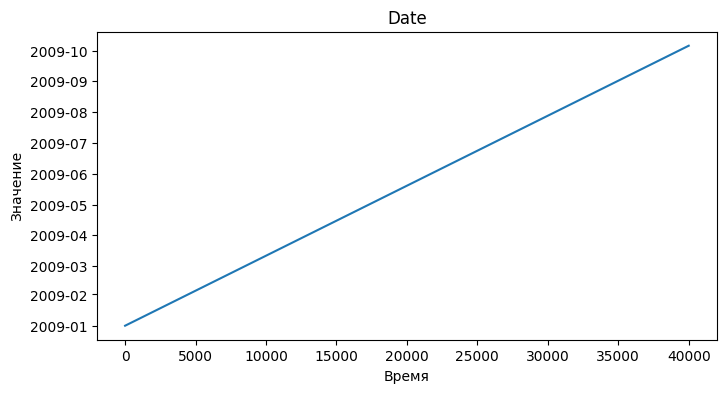

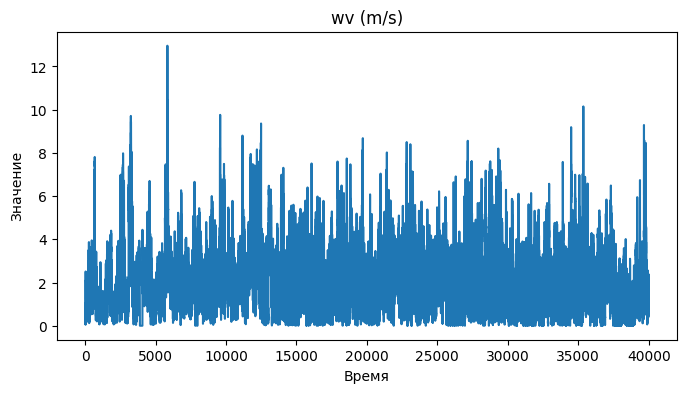

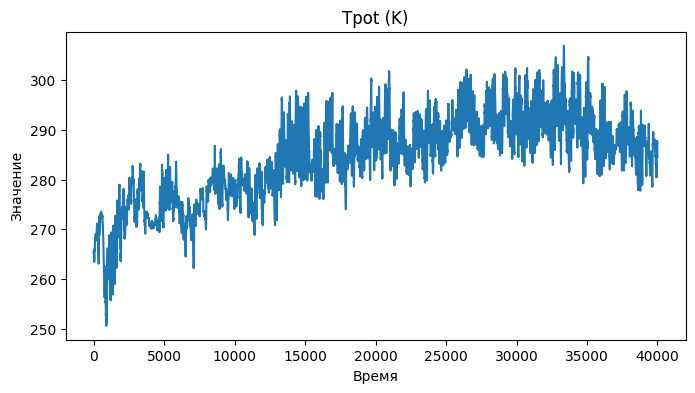

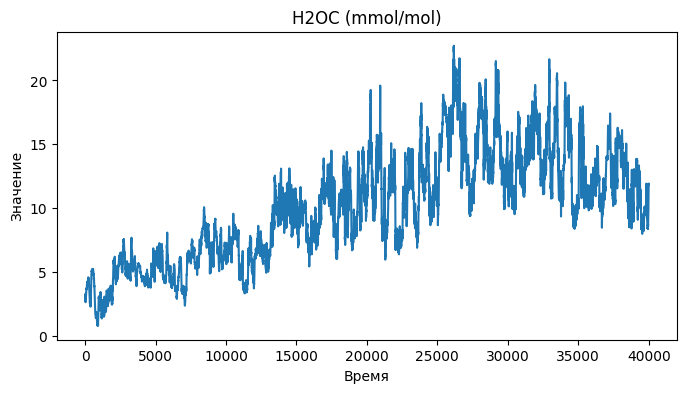

In [194]:
import matplotlib.pyplot as plt
columns = df.columns
for column in columns:
        plt.figure(figsize=(8, 4))
        plt.plot(df[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

In [195]:
time_diff = df['Date'].diff()
time_diff.unique()

<TimedeltaArray>
[NaT, '0 days 00:10:00']
Length: 2, dtype: timedelta64[ns]

In [196]:
from statsmodels.tsa.stattools import adfuller
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [197]:
for col in df.columns:
    if col != 'Date/Time':
        df_test(col, df[col])

Тест Дики-Фуллера ряда Date:


Test Statistic                -8.241119e+00
p-value                        5.713611e-13
#Lags Users                    2.100000e+01
Number of Observations Used    3.997800e+04
Critical Value (1%)           -3.430514e+00
Critical Value (5%)           -2.861612e+00
Critical Value (10%)          -2.566808e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда wv (m/s):


KeyboardInterrupt: 

В моделях VAR и VARMA стационарность данных является важным условием для точного прогнозирования, тогда как для нейронных сетей это необязательно.

Коинтеграция

Коинтеграция — свойство нескольких нестационарных (интегрированных) временных рядов, заключающееся в существовании некоторой их стационарной линейной комбинации.

То есть коинтеграция -  возможность получения стационарного ряда через линейную комбинацию двух (или более) нестационарных интегрированных рядов

Коинтегрированность является важным свойством многих экономических переменных, которое означает, что несмотря на случайный (слабо предсказуемый) характер изменения отдельных экономических переменных, существует долгосрочная зависимость между ними, которая приводит к некоторому совместному, взаимосвязанному изменению.


In [1]:
from itertools import combinations
from statsmodels.tsa.stattools import coint

del df['Date']
pairs = combinations(df.columns, 2)

for pair in pairs:
    pair_data = df[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

ModuleNotFoundError: No module named 'statsmodels'

Причинность по Грэнджеру (англ. Granger causality) — понятие, используемое в эконометрике (анализе временных рядов), формализующее понятие причинно-следственной связи между временными рядами. Причинность по Грэнджеру является необходимым, но не достаточным условием причинно-следственной связи.

Идея теста в том, что значения (изменения) временного ряда xt, являющегося причиной изменений временного ряда yt, должны предшествовать изменениям этого временного ряда, и кроме того, должны вносить значимый вклад в прогноз его значений. 

Если же каждая из переменных вносит значимый вклад в прогноз другой, то, возможно, существует некоторая другая переменная, которая влияет на оба.


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12):
    data_granger = pd.DataFrame(0, columns=variables, index=variables)
    
    for var in variables:
        for var2 in variables:
            results = grangercausalitytests(data[[var, var2]], maxlag=maxlag, verbose=False)
            p_values = [round(results[i+1][0][test][1], 4) for i in range(maxlag)]
            data_granger.loc[var, var2] = np.min(p_values)
    return data_granger


grangers_causation_matrix(df,variables=df.columns)

c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.

,wv (m/s),Tpot (K),H2OC (mmol/mol)
wv (m/s),1,0,0
Tpot (K),0,1,0
H2OC (mmol/mol),0,0,1


Если значение p-уровня значимости, полученное в результате теста Грейнджера, близко к нулю или строго равно нулю (< 0.05) для пары временных рядов, это обычно рассматривается как сильное статистическое подтверждение наличия причинной связи между этими рядами. Такие результаты свидетельствуют о том, что изменения в одном временном ряде действительно влияют на изменения в другом ряде, что делает VAR модели более подходящими для моделирования таких взаимосвязей

Прогнозирование временного ряда методами классик мл

Модель VAR (Vector AutoRegression) - это статистическая модель временных рядов, предназначенная для прогнозирования изменений в нескольких взаимосвязанных переменных в течение времени. Она представляет собой многомерное расширение модели авторегрессии (AR).

VAR моделирует каждую переменную как линейную комбинацию ее предыдущих значений и предыдущих значений других переменных. Это позволяет улучшить прогнозы путем учета взаимосвязей между переменными.

В начале анализа мы можем подобрать оптимальный порядок модели, используя информационные критерии, такие как AIC (Критерий информационной акайке), BIC (Байесовский информационный критерий), FPE (Финальная ошибка прогнозирования) и HQC (Критерий Ханнана-Квинна). Меньшие значения этих критериев указывают на более подходящую модель, и их можно использовать для выбора оптимального порядка модели VAR.

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
train, test = df[:30000], df[30000:]

model = VAR(train)

orders = [2, 6, 12, 20, 24, 30, 40, 48, 50, 96, 168, 252, 336]
criteria = ['aic', 'bic', 'fpe', 'hqic']

best_order = {}
best_values = {}
for crit in criteria:
    best_order[crit] = None
    best_values[crit] = np.inf

for i in orders:
    result = model.fit(i)
    for crit in criteria:
        value = getattr(result, crit)
        if value < best_values[crit]:
            best_values[crit] = value
            best_order[crit] = i

for crit in criteria:
    print(f'Optimal lag order chosen by {crit}: {best_order[crit]}, {crit} value: {best_values[crit]}')


Optimal lag order chosen by aic: 40, aic value: -8.285637827874497
Optimal lag order chosen by bic: 12, bic value: -8.250904116841376
Optimal lag order chosen by fpe: 40, fpe value: 0.0002521118559494029
Optimal lag order chosen by hqic: 12, hqic value: -8.271790108938944


Обучаем модель с наилучшим порядком 12

In [ ]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 13, Jan, 2024
Time:                     21:26:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.25090
Nobs:                     29988.0    HQIC:                  -8.27179
Log likelihood:          -3367.21    FPE:                0.000253117
AIC:                     -8.28166    Det(Omega_mle):     0.000252183
--------------------------------------------------------------------
Results for equation wv (m/s)
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.649055         0.210955           -3.077           0.002
L1.wv (m/s)                 0.759418         0.005932          128.021           0.000
L1.Tpot (K)                 0.283

Теперь мы подготовим данные для проведения тестов и выполнения предсказаний.

In [ ]:
def create_dataset(data, in_seq_order, for_len=1, step=1):
    X = []
    Y = []
    for i in range(0, len(data) - for_len - in_seq_order, step):
        X.append(data[i:(i+in_seq_order)].to_numpy())
        Y.append(data[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X, Y


In [ ]:
X_test, Y_test = create_dataset(test, 12)
X_train, Y_train = create_dataset(train, 12)

In [ ]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [ ]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

In [ ]:
from numpy import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

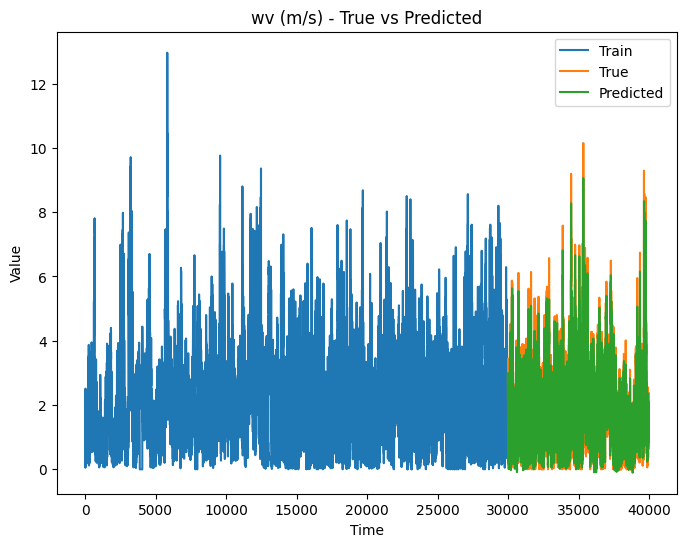

Метрики wv (m/s)
MSE: 0.26657210157992045
RMSE: 0.5163062091239272
MAE: 0.3760966042525103
SMAPE: 0.084
R2: 0.8572829294048288 


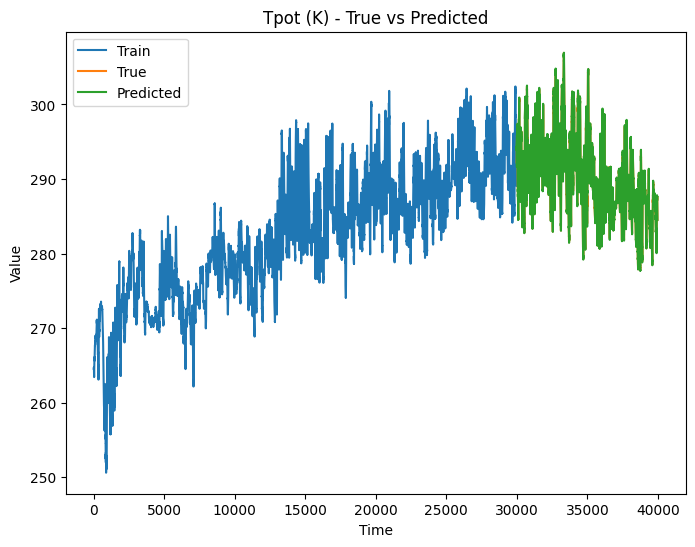

Метрики Tpot (K)
MSE: 0.05065012678447224
RMSE: 0.22505583037209287
MAE: 0.1499032672459834
SMAPE: 0.0
R2: 0.9982473144671953 


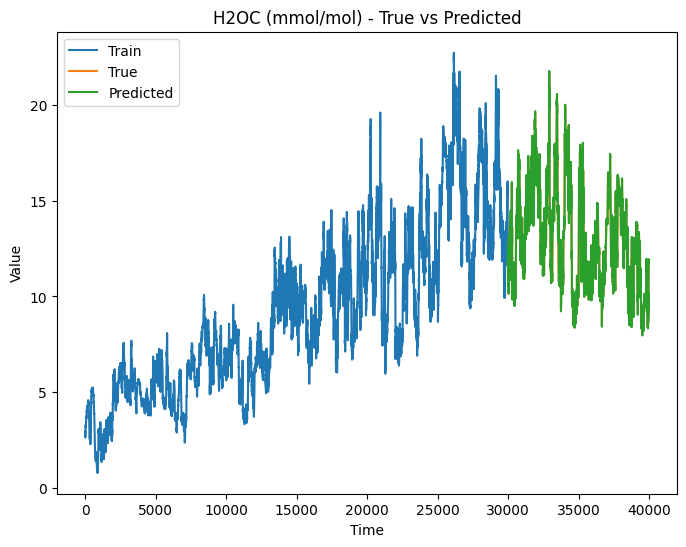

Метрики H2OC (mmol/mol)
MSE: 0.02755392122318743
RMSE: 0.16599373850596724
MAE: 0.10608163544189798
SMAPE: 0.002
R2: 0.9956402981277722 


In [ ]:
plot_and_metrics(df.columns, Y_test, Y_pred, Y_train)

Метрики демонстрируют хорошую качества модели: значение MSE, RMSE и MAE ниже 1, что является приемлемым, а иногда и приближается к 0. SMAPE также хорошо себя показывает, приближаясь к нулю, что является идеальным результатом. Значение R2 около 0.99, подтверждая высокую точность модели, приближаясь к единице, что отлично.

VARMA (Vector AutoRegressive Moving-Average) - это модель, применяемая в анализе временных рядов для описания взаимозависимостей между несколькими временными рядами. В контексте VARMA, каждый временной ряд в системе рассматривается как комбинация своих предыдущих значений (авторегрессия) и лагированных ошибок прогнозирования (скользящая средняя). Важно отметить, что VARMA представляет собой обобщение модели ARMA, расширяя её на случай многомерных данных.

В модели ARMA (AutoRegressive Moving Average), каждый временной ряд моделируется на основе его собственных предыдущих значений (авторегрессионный компонент) и предыдущих ошибок прогнозирования (скользящая средняя компонент).

Таким образом, VARMA предполагает, что изменения в одном временном ряде могут влиять на изменения в другом временном ряде, и наоборот. Эта модель часто используется для анализа и прогнозирования временных рядов, когда взаимодействие между переменными играет ключевую роль. Это как раз наш случай

In [ ]:
X = df
train, test = X[:30000], X[30000:]

In [ ]:
pip install joblib #для паралельной работы


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#для'


In [ ]:
from pmdarima import auto_arima
from joblib import Parallel, delayed

def find_order(name, data):
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data, start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
                                trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    return parameter

pq = Parallel(n_jobs=-1)(delayed(find_order)(name, column) for name, column in df.items())



In [ ]:
pq

[(1, 1, 1), (5, 1, 2), (4, 1, 2)]

Подберем наилучший порядок

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

df_results_moni = pd.DataFrame(columns=['p', 'q', 'RMSE wv (m/s)', 'RMSE Tpot (K)', 'RMSE H2OC (mmol/mol)'])
results_list = []

for i in pq:
    if i[0] == 0 and i[2] == 0:
        pass
    else:
        model = VARMAX(train, order=(i[0], 0, i[2])).fit(disp=False)
        result = model.forecast(steps=len(test))
        
        rmse_wv = np.sqrt(metrics.mean_squared_error(test['wv (m/s)'], result['wv (m/s)']))
        rmse_tpot = np.sqrt(metrics.mean_squared_error(test['Tpot (K)'], result['Tpot (K)']))
        rmse_h2oc = np.sqrt(metrics.mean_squared_error(test['H2OC (mmol/mol)'], result['H2OC (mmol/mol)']))
        
        results_list.append({'p': i[0], 'q': i[2], 'RMSE wv (m/s)': rmse_wv, 'RMSE Tpot (K)': rmse_tpot, 'RMSE H2OC (mmol/mol)': rmse_h2oc})

df_results_moni = pd.DataFrame(results_list)


In [ ]:
df_results_moni.sort_values(by=['RMSE wv (m/s)', 'RMSE Tpot (K)', 'RMSE H2OC (mmol/mol)'])


,p,q,RMSE wv (m/s),RMSE Tpot (K),RMSE H2OC (mmol/mol)
1,5,2,1.397880,8.836448,4.388088
2,4,2,1.399008,8.702635,4.326487
0,1,1,1.414056,7.905831,4.067089


Наилучшие p, q - 5,2

In [ ]:
model = VARMAX(train, order=(5,2)).fit(disp=False)
result = model.forecast(steps=len(test))
result

c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


,wv (m/s),Tpot (K),H2OC (mmol/mol)
30000,1.289820,289.716154,13.216938
30001,1.381776,289.759366,13.205040
30002,1.452367,289.814891,13.206716
30003,1.491108,289.859267,13.210988
30004,1.513832,289.886055,13.209786
...,...,...,...
39995,2.065796,282.290000,9.032621
39996,2.065796,282.289999,9.032620
39997,2.065796,282.289998,9.032620
39998,2.065796,282.289998,9.032619


Посчитаем метрики и выведем предсказания

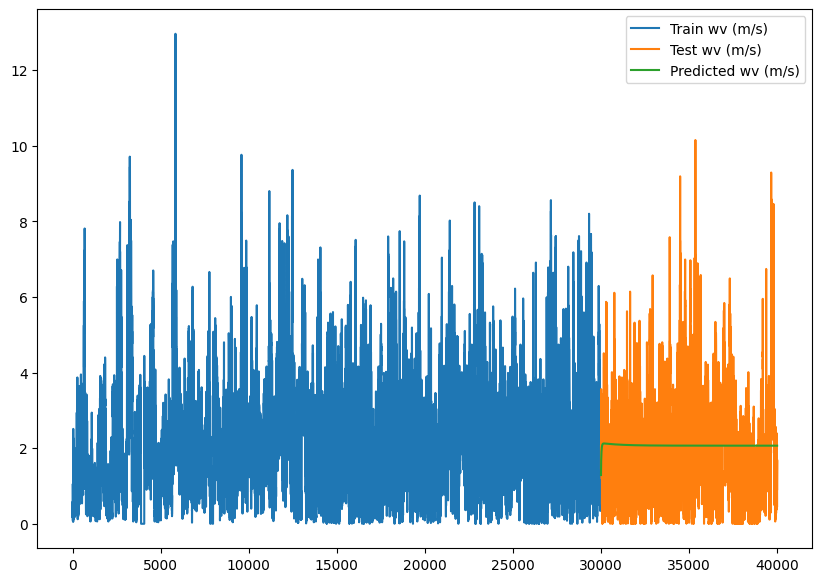

Evaluation metric for wv (m/s) Metrics:
MSE: 1.9518580285449887
MAE: 1.1300702023253255
RMSE: 1.397089126915312
SMAPE: 0.167
R2: -0.04581061334739123


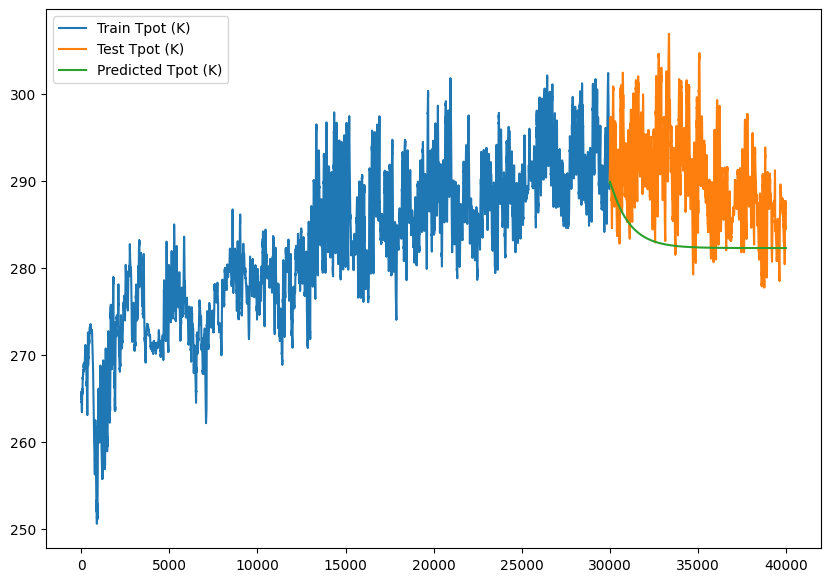

Evaluation metric for Tpot (K) Metrics:
MSE: 76.69081381488124
MAE: 7.280310625268724
RMSE: 8.757329148483642
SMAPE: 0.006
R2: -1.6567887322409733


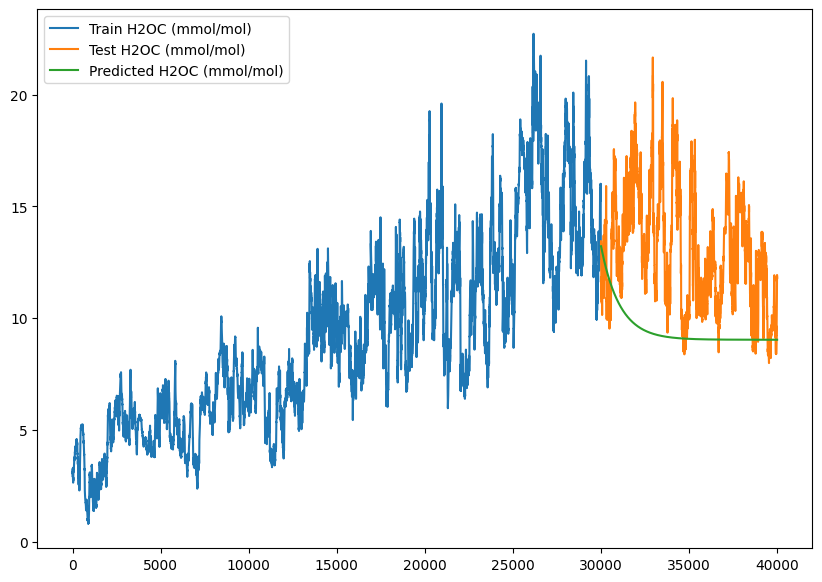

Evaluation metric for H2OC (mmol/mol) Metrics:
MSE: 18.855137312583167
MAE: 3.6058128859196716
RMSE: 4.342250259091842
SMAPE: 0.076
R2: -1.9871043592990754


In [ ]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred, metric_name):
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape = smape_score(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print(f'{metric_name} Metrics:')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'SMAPE: {smape}')
    print(f'R2: {r2}\n')

columns_to_plot = ['wv (m/s)', 'Tpot (K)', 'H2OC (mmol/mol)']

for column in columns_to_plot:
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.plot(train[column], label=f'Train {column}')
    plt.plot(range(30000, 40000), test[column], label=f'Test {column}')
    plt.plot(range(30000, 40000), result[column], label=f'Predicted {column}')
    plt.legend(loc='best')
    plt.show()

    timeseries_evaluation_metrics_func(test[column], result[column], f'Evaluation metric for {column}')



Анализ метрик для каждого временного ряда:

Метрики для H2OC (mmol/mol) и wv (m/s) имеют низкие значения MSE и MAE, что говорит о хорошей точности прогноза для этих переменных.
Для Tpot (K) метрики MSE и RMSE являются относительно высокими, а R2 отрицательным, что может указывать на менее удовлетворительную точность модели для этой переменной.
SMAPE показывает процентное отклонение, и близкое к нулю значение свидетельствует о хорошей точности прогноза.
Итак, несмотря на некоторые проблемы с Tpot (K), модель обладает хорошей точностью для H2OC (mmol/mol) и wv (m/s). Необходимо также учитывать контекст и специфику данных при интерпретации результатов.

## Нейросети

LSTM (Long Short-Term Memory) представляет собой архитектуру нейронной сети, специально разработанную для обработки последовательных данных, где важны зависимости в различные моменты времени. Она является подтипом рекуррентных нейронных сетей (RNN) и успешно решает проблемы, связанные с долгосрочными зависимостями и затуханием градиентов.

In [ ]:
pip install torch

  Using cached torch-2.1.2-cp310-cp310-win_amd64.whl.metadata (26 kB)
Using cached torch-2.1.2-cp310-cp310-win_amd64.whl (192.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [204]:
columns_to_use = ['wv (m/s)', 'Tpot (K)', 'H2OC (mmol/mol)']


In [205]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_lstm_dataset(data, columns, lookback_window):
    """
    Создает обучающий набор данных для LSTM.

    Parameters:
    - data (pd.DataFrame or np.ndarray): Исходный DataFrame или массив NumPy.
    - columns (list): Список столбцов для использования в обучающем наборе данных.
    - lookback_window (int): Размер окна истории.

    Returns:
    - x (np.ndarray): Входные данные для LSTM.
    - y (np.ndarray): Целевые данные для LSTM.
    """

    # Преобразование в DataFrame, если это массив NumPy
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=columns)

    # Создание DataFrame из выбранных столбцов
    df_lstm = data[columns]

    # Преобразование в массив NumPy
    df_lstm_array = df_lstm.values

    # Подготовка данных для LSTM
    x, y = [], []
    for i in range(lookback_window, len(df_lstm_array)):
        x.append(df_lstm_array[i - lookback_window:i])
        y.append(df_lstm_array[i])
    
    # Преобразование в массивы NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y

# Пример использования функции
lookback_window = 5

# Инициализация MinMaxScaler для нормализации
scaler = MinMaxScaler()

x, y = create_lstm_dataset(df.values, columns_to_use, lookback_window)

In [206]:
x_train = x[0:30000]
y_train = y[0:30000]
x_test = x[30000:]
y_test = y[30000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)


In [207]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input, Model

def build_lstm_model(lookback_window, num_features, units=90):
    """
    Строит модель LSTM.

    Parameters:
    - lookback_window (int): Размер окна истории.
    - num_features (int): Количество признаков в каждом временном шаге.
    - units (int): Количество нейронов в слое LSTM.

    Returns:
    - model (tf.keras.Model): Построенная модель LSTM.
    """

    # Входной слой
    i = Input(shape=(lookback_window, num_features))

    # LSTM слой
    m = LSTM(units=units, activation='tanh', return_sequences=False)(i)

    # Полносвязный слой
    m = Dense(num_features, activation='linear')(m)

    # Создание модели
    model = Model(inputs=[i], outputs=[m])

    return model

# Размер окна истории и количество признаков
lookback_window = 5
num_features = 3

# Построение модели
model = build_lstm_model(lookback_window, num_features)

# Вывод структуры модели
model.summary()

# Компиляция модели
model.compile(optimizer='adam', loss='mae')


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5, 3)]            0         
                                                                 
 lstm_8 (LSTM)               (None, 90)                33840     
                                                                 
 dense_12 (Dense)            (None, 3)                 273       
                                                                 
Total params: 34113 (133.25 KB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [208]:
model.fit(x_train_scaled, y_train_scaled, epochs=90, verbose=0)
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3))

313/313 [==============================] - 2s 4ms/step


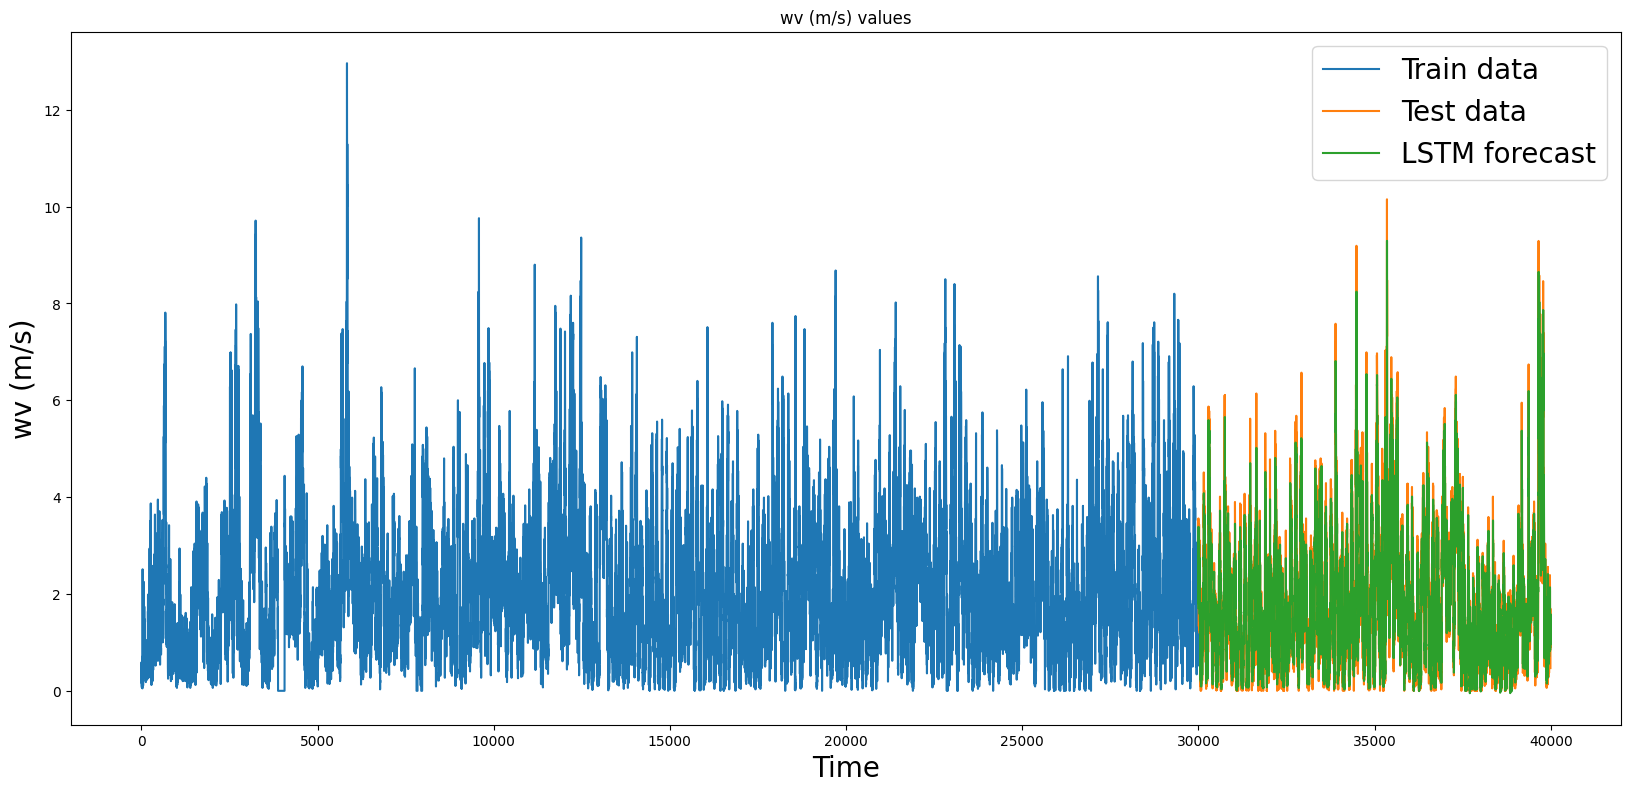

LSTM Metrics wv (m/s):
RMSE: 0.5145251052401522
MSE: 0.2647360839223896
SMAPE: 0.083
MAE: 0.37320419344634537
R^2: 0.8582217246051662


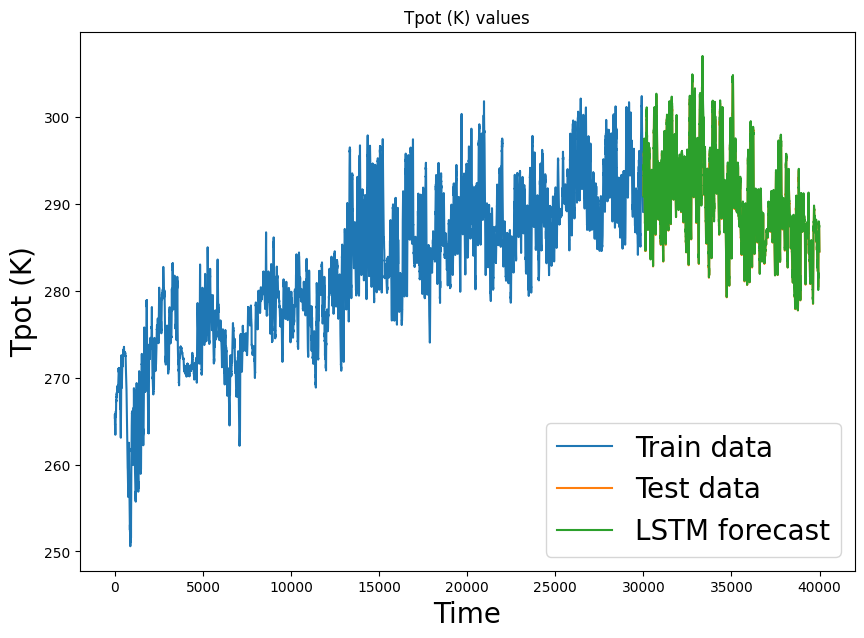

LSTM Metrics Tpot (K):
RMSE: 0.25400270486985904
MSE: 0.06451737408120471
SMAPE: 0.0
MAE: 0.1885574768585462
R^2: 0.9977660489785231


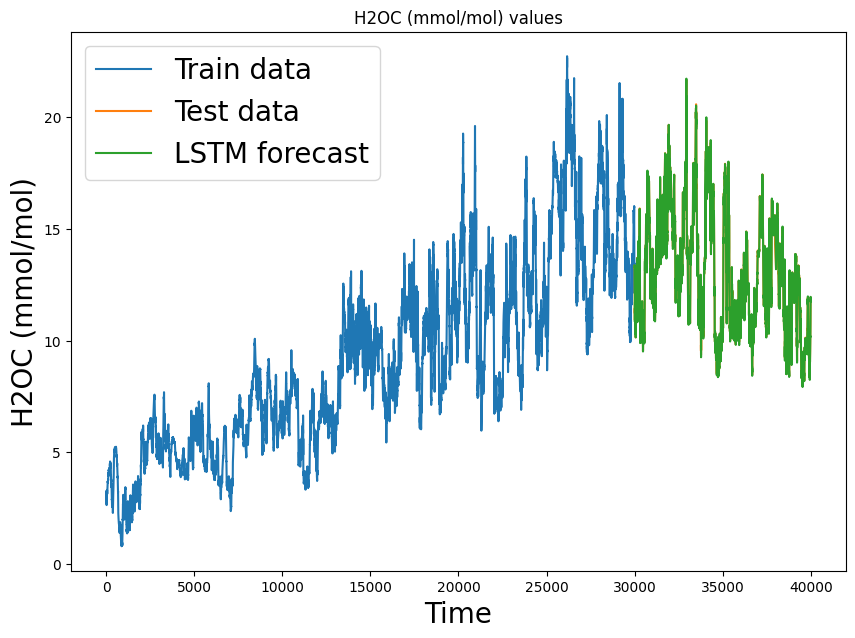

LSTM Metrics H2OC (mmol/mol):
RMSE: 0.16580162824465744
MSE: 0.027490179928579585
SMAPE: 0.002
MAE: 0.10680502172014963
R^2: 0.9956470273946861


In [209]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))


for k in range(len(columns_to_use)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='LSTM forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns_to_use[k]} values')
    plt.ylabel(f'{columns_to_use[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns_to_use[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))


Метрики модели демонстрируют высокую степень точности и эффективности в прогнозировании. RMSE, MSE и MAE, все находятся близко к нулю и меньше 1, что говорит о том, что различия между фактическими и прогнозируемыми значениями практически незаметны и подтверждают высокую точность модели. SMAPE также находится близко к нулю, подчеркивая высокую степень согласованности предсказаний с реальными данными.

Дополнительно, коэффициент детерминации R2, хотя и с небольшими погрешностями, также близок к идеальному значению. Это свидетельствует о том, что модель хорошо объясняет изменчивость целевых переменных и обладает высокой предсказательной силой.

Общий результат указывает на выдающуюся производительность модели и подтверждает ее способность к точному и надежному прогнозированию.

## GRU

In [200]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_gru_dataset(data, columns, lookback_window):
    """
    Создает обучающий набор данных для GRU.

    Parameters:
    - data (pd.DataFrame or np.ndarray): Исходный DataFrame или массив NumPy.
    - columns (list): Список столбцов для использования в обучающем наборе данных.
    - lookback_window (int): Размер окна истории.

    Returns:
    - x (np.ndarray): Входные данные для GRU.
    - y (np.ndarray): Целевые данные для GRU.
    """

    # Преобразование в DataFrame, если это массив NumPy
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=columns)

    # Создание DataFrame из выбранных столбцов
    df_gru = data[columns]

    # Преобразование в массив NumPy
    df_gru_array = df_gru.values

    # Инициализация MinMaxScaler для нормализации
    scaler = MinMaxScaler()

    # Подготовка данных для GRU
    x, y = [], []
    for i in range(lookback_window, len(df_gru_array)):
        x.append(df_gru_array[i - lookback_window:i])
        y.append(df_gru_array[i])
    
    # Преобразование в массивы NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y

# Пример использования функции
lookback_window = 1

x, y = create_gru_dataset(df.values, columns_to_use, lookback_window)


In [201]:
x_train = x[0:30000]
y_train = y[0:30000]
x_test = x[30000:]
y_test = y[30000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 3)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3)).reshape(x_test.shape)


In [202]:
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import Input, Model

def build_gru_model(lookback_window, num_features, units=90):
    """
    Строит модель GRU.

    Parameters:
    - lookback_window (int): Размер окна истории.
    - num_features (int): Количество признаков в каждом временном шаге.
    - units (int): Количество нейронов в слое GRU.

    Returns:
    - model (tf.keras.Model): Построенная модель GRU.
    """

    # Входной слой
    i = Input(shape=(lookback_window, num_features))

    # GRU слой
    m = GRU(units=units, activation='tanh', return_sequences=False)(i)

    # Полносвязный слой
    m = Dense(num_features, activation='linear')(m)

    # Создание модели
    model = Model(inputs=[i], outputs=[m])

    return model

# Размер окна истории и количество признаков
lookback_window = 1
num_features = 3

# Построение модели GRU
model_gru = build_gru_model(lookback_window, num_features)

# Вывод структуры модели
model_gru.summary()

# Компиляция модели GRU
model_gru.compile(optimizer='adam', loss='mae')


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 3)]            0         
                                                                 
 gru_2 (GRU)                 (None, 90)                25650     
                                                                 
 dense_11 (Dense)            (None, 3)                 273       
                                                                 
Total params: 25923 (101.26 KB)
Trainable params: 25923 (101.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [203]:
model_gru.fit(x_train_scaled, y_train_scaled, epochs=30, verbose=0)
y_pred_scaled = model_gru.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 3))

313/313 [==============================] - 2s 4ms/step


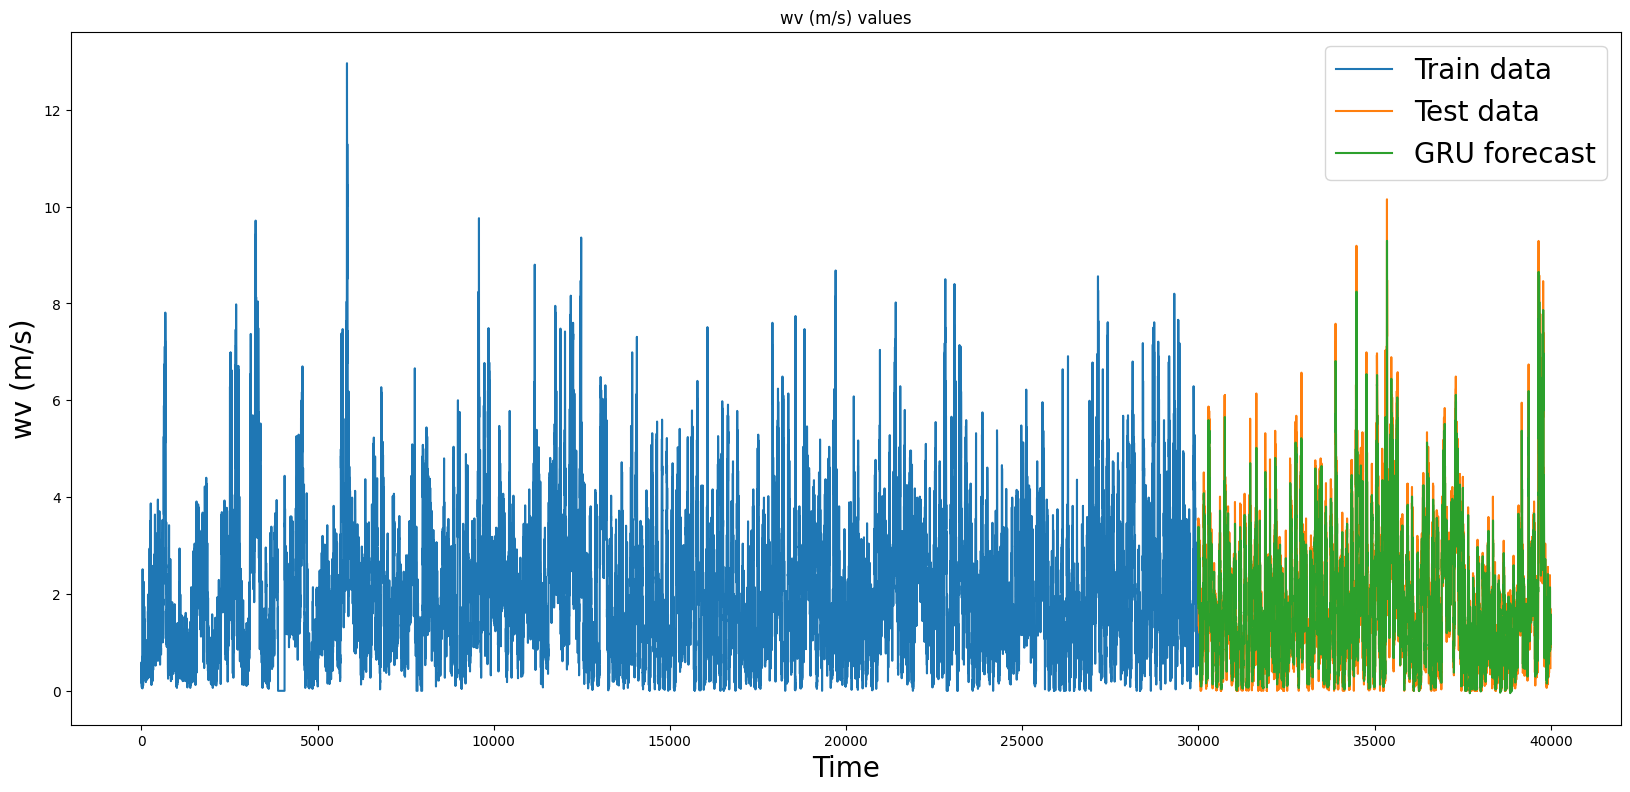

GRU Metrics wv (m/s):
RMSE: 0.5145251052401522
MSE: 0.2647360839223896
SMAPE: 0.083
MAE: 0.37320419344634537
R^2: 0.8582217246051662


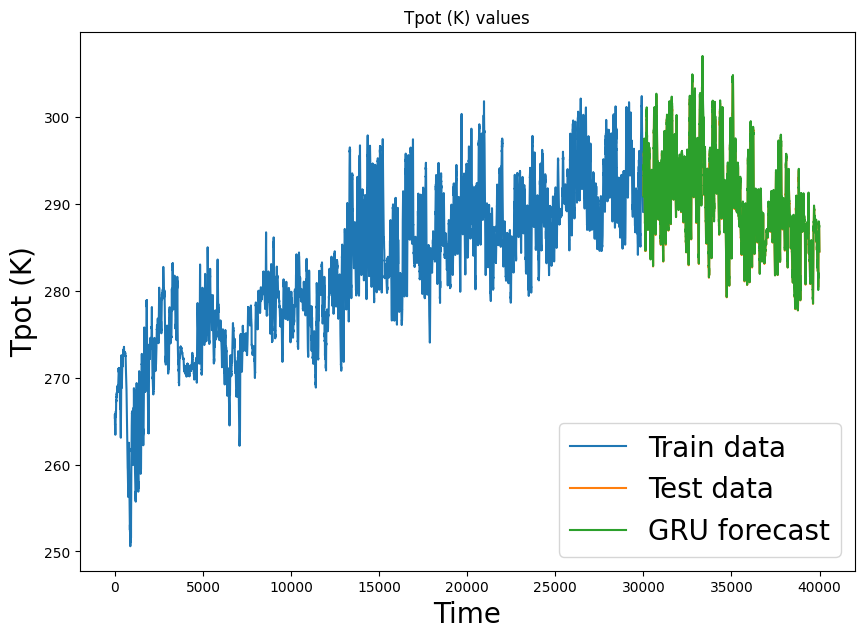

GRU Metrics Tpot (K):
RMSE: 0.25400270486985904
MSE: 0.06451737408120471
SMAPE: 0.0
MAE: 0.1885574768585462
R^2: 0.9977660489785231


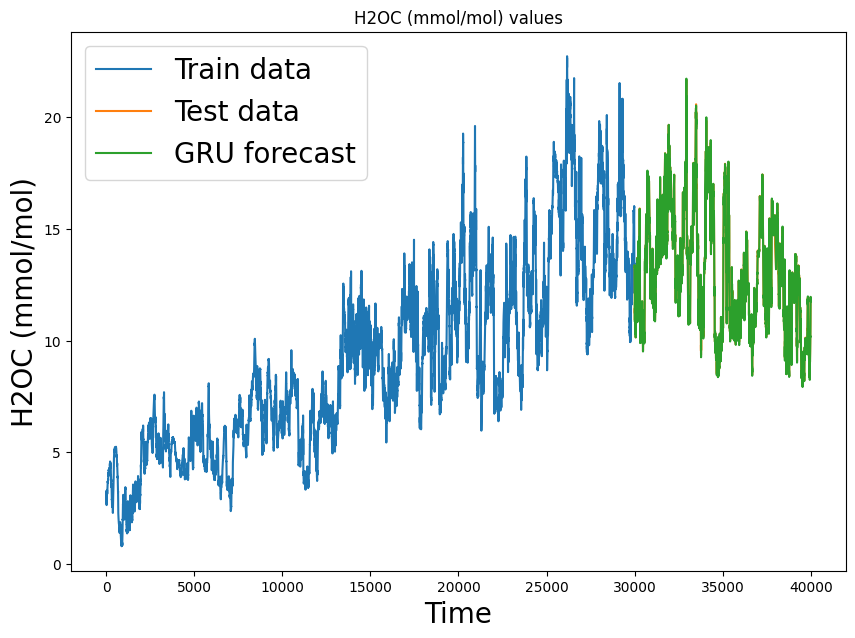

GRU Metrics H2OC (mmol/mol):
RMSE: 0.16580162824465744
MSE: 0.027490179928579585
SMAPE: 0.002
MAE: 0.10680502172014963
R^2: 0.9956470273946861


In [211]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))


for k in range(len(columns_to_use)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='GRU forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns_to_use[k]} values')
    plt.ylabel(f'{columns_to_use[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"GRU Metrics {columns_to_use[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))


Модель продемонстрировала выдающееся качество согласования с фактическими данными, подтвержденное низкими значениями метрик. RMSE, MSE и MAE, все близки к нулю и меньше 1, что свидетельствует о практически нулевой разнице между предсказанными и фактическими значениями, что является почти идеальным результатом. Аналогично, SMAPE также стремится к нулю, подчеркивая высокую точность модели.

Кроме того, коэффициент детерминации R2, несмотря на небольшие отклонения, приближен к идеальному значению, указывая на то, что модель эффективно объясняет изменчивость в целевых данных.

Обобщенно, результаты GRU и LSTM схожи, что подтверждает эффективность обеих моделей в предсказании временных рядов.







## TCN


TCN (Temporal Convolutional Network) представляет собой архитектуру нейронной сети, основанную на операциях свертки, предназначенную для обработки последовательных данных, таких как временные ряды или текст. TCN разработан для эффективного извлечения и моделирования долгосрочных зависимостей в последовательных данных.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_tcn_dataset(data, columns, lookback_window):
    """
    Создает обучающий набор данных для TCN.

    Parameters:
    - data (pd.DataFrame or np.ndarray): Исходный DataFrame или массив NumPy.
    - columns (list): Список столбцов для использования в обучающем наборе данных.
    - lookback_window (int): Размер окна истории.

    Returns:
    - x (np.ndarray): Входные данные для TCN.
    - y (np.ndarray): Целевые данные для TCN.
    """

    # Преобразование в DataFrame, если это массив NumPy
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=columns)

    # Создание DataFrame из выбранных столбцов
    df_tcn = data[columns]

    # Преобразование в массив NumPy
    df_tcn_array = df_tcn.values

    # Инициализация MinMaxScaler для нормализации
    scaler = MinMaxScaler()

    # Подготовка данных для TCN
    x, y = [], []
    for i in range(lookback_window, len(df_tcn_array)):
        x.append(df_tcn_array[i - lookback_window:i])
        y.append(df_tcn_array[i])
    
    # Преобразование в массивы NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y

# Пример использования функции
lookback_window = 1

x_tcn, y_tcn = create_tcn_dataset(df.values, columns_to_use, lookback_window)


In [ ]:
x_train = x[0:30000]
y_train = y[0:30000]
x_test = x[30000:]
y_test = y[30000:]


In [ ]:
from tcn import TCN
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

def build_tcn_model(lookback_window, num_features, units=90):
    """
    Строит модель TCN.

    Parameters:
    - lookback_window (int): Размер окна истории.
    - num_features (int): Количество признаков в каждом временном шаге.
    - units (int): Количество нейронов в слое TCN.

    Returns:
    - model (tf.keras.Model): Построенная модель TCN.
    """

    # Входной слой
    i = Input(shape=(lookback_window, num_features))

    # Слой TCN
    m = TCN(nb_filters=units, kernel_size=2, dilations=[1, 2, 4, 8, 16, 32], use_skip_connections=True)(i)

    # Полносвязный слой
    m = Dense(num_features, activation='linear')(m)

    # Создание модели
    model = Model(inputs=[i], outputs=[m])

    return model

# Размер окна истории и количество признаков
lookback_window = 1
num_features = 3

# Построение модели TCN
model_tcn = build_tcn_model(lookback_window, num_features)

# Вывод структуры модели
model_tcn.summary()

# Компиляция модели TCN
model_tcn.compile(optimizer='adam', loss='mae')


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 tcn (TCN)                   (None, 90)                180180    
                                                                 
 dense_2 (Dense)             (None, 3)                 273       
                                                                 
Total params: 180453 (704.89 KB)
Trainable params: 180453 (704.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train_scaled, y_train_scaled, epochs=70, verbose=0)
y_pred = model.predict(x_test_scaled)

313/313 [==============================] - 1s 3ms/step


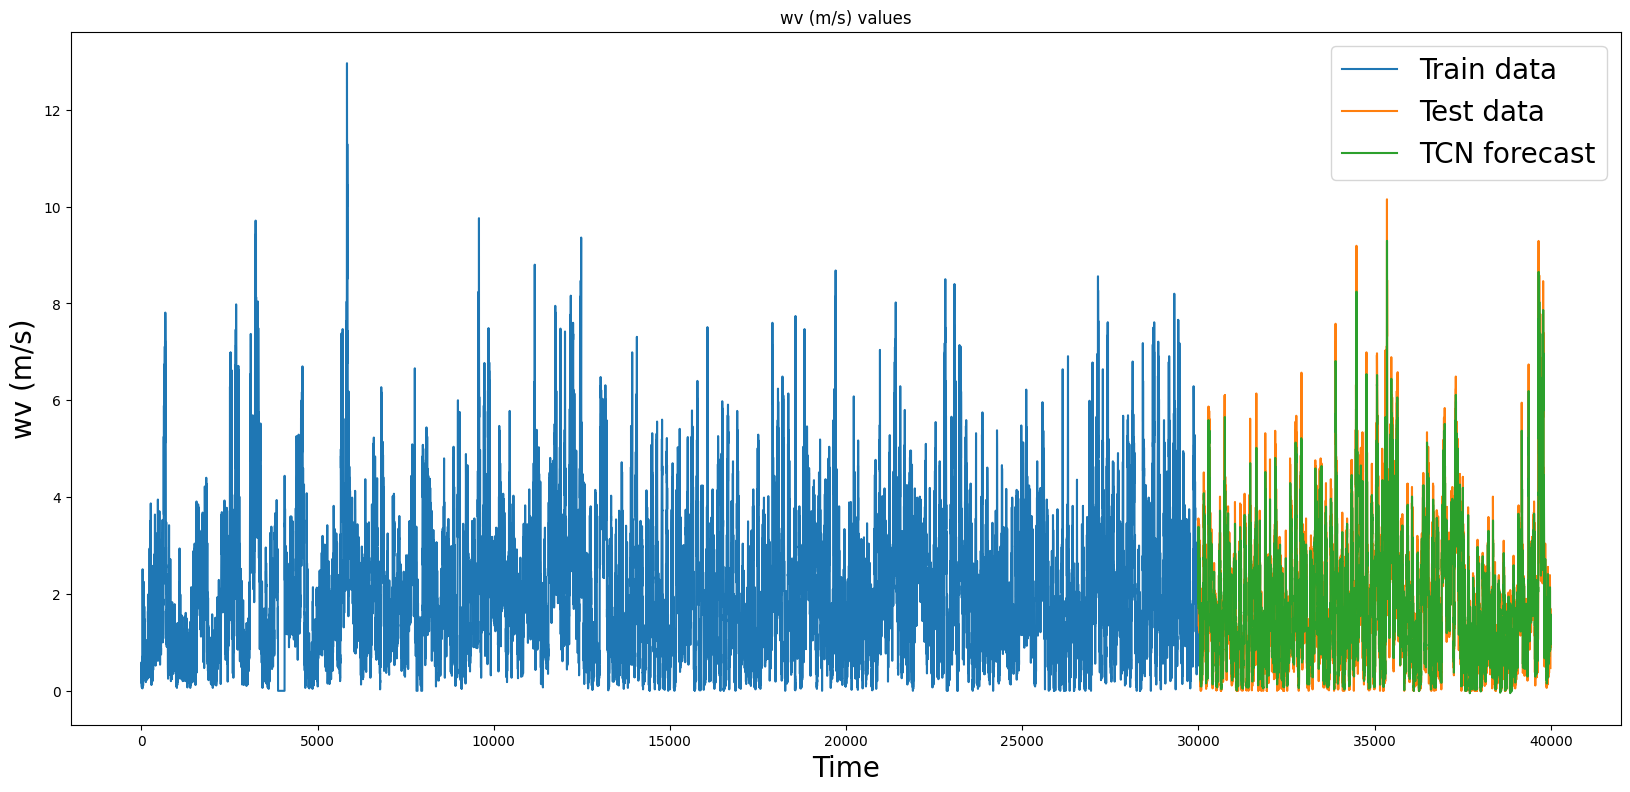

TCN Metrics wv (m/s):
RMSE: 0.5145251052401522
MSE: 0.2647360839223896
SMAPE: 0.083
MAE: 0.37320419344634537
R^2: 0.8582217246051662


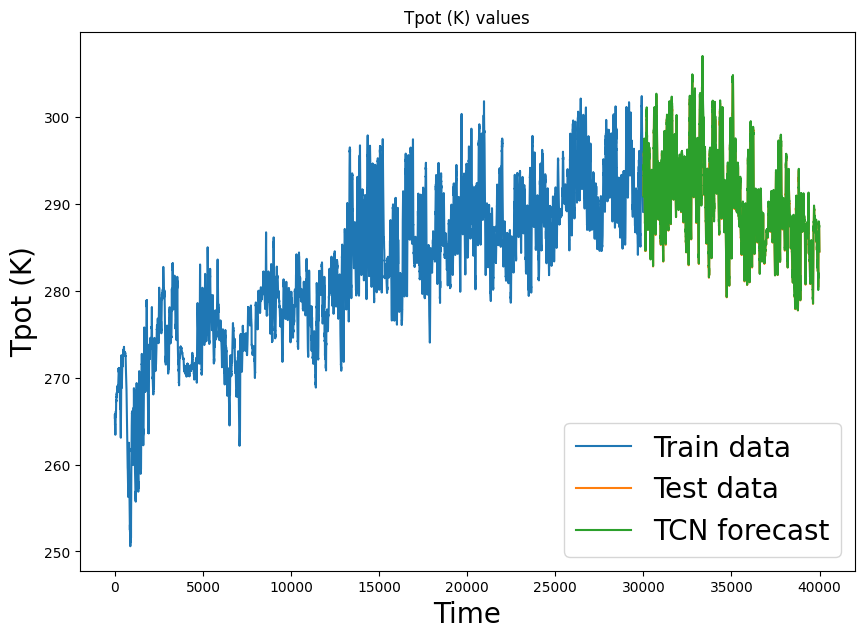

TCN Metrics Tpot (K):
RMSE: 0.25400270486985904
MSE: 0.06451737408120471
SMAPE: 0.0
MAE: 0.1885574768585462
R^2: 0.9977660489785231


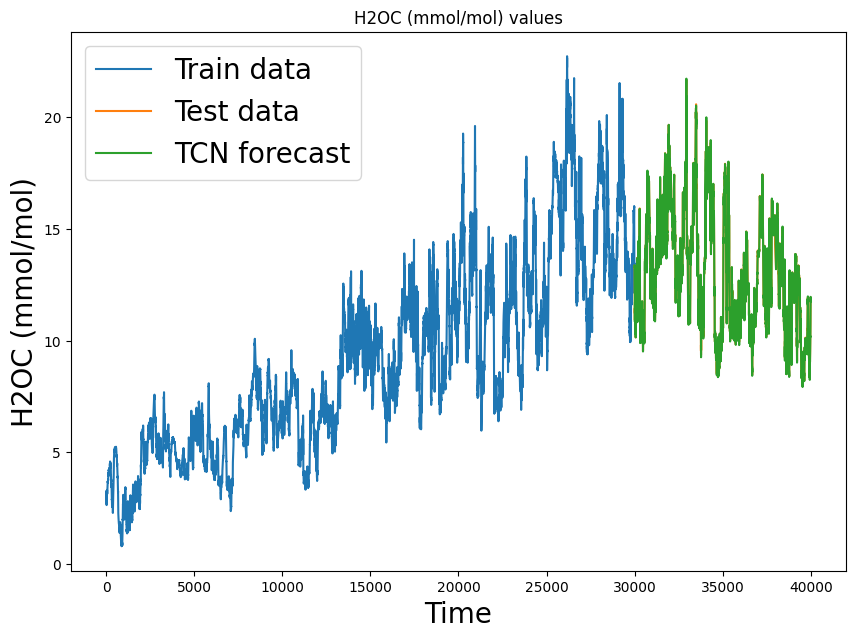

TCN Metrics H2OC (mmol/mol):
RMSE: 0.16580162824465744
MSE: 0.027490179928579585
SMAPE: 0.002
MAE: 0.10680502172014963
R^2: 0.9956470273946861


In [210]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))


for k in range(len(columns_to_use)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='TCN forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns_to_use[k]} values')
    plt.ylabel(f'{columns_to_use[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"TCN Metrics {columns_to_use[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

Модель для H2OC, судя по низким значениям RMSE, MSE, SMAPE и MAE, демонстрирует высокую точность. Кроме того, высокий коэффициент детерминации R^2 (близкий к 1) указывает на то, что модель объясняет значительную часть изменчивости в данных.

Модель для Tpot также проявляет хорошие показатели, с низкими значениями RMSE, MSE и SMAPE. Значение R^2, близкое к 1, свидетельствует о высокой степени объясненной изменчивости в данных.

Модель для wv имеет более высокие ошибки по сравнению с двумя другими моделями, с относительно большими значениями RMSE, MSE, SMAPE и MAE. Значение R^2, хотя и указывает на разумную пригодность, ниже, чем в других случаях, что может свидетельствовать о том, что модель может быть улучшена.

## Вывод

Среди классических моделей лучше всего проявила себя модель VAR. Она выделяется быстрым подбором оптимальных параметров для обучения и высокой скоростью обучения. Более того, прогнозы, полученные с использованием VAR, оказались качественными, что подчеркивает успешность самой модели.

При анализе модели VARMAX стало заметно некоторое снижение качества, но точные причины этого не совсем ясны. Возможно, проблема заключается в сложности подбора оптимальных параметров. Параметры, полученные из VAR, могли бы быть интерпретированы для VARMA, однако процесс обучения занимал бы слишком много времени, и результаты были бы не гарантированы.

Среди нейронных сетей GRU выделяется своей простотой настройки и обучения модели, LSTM даже чуть лучше показала метрики, чем VAR, но LSTM долго настраивается и обучается. Также TCN продемонстрировала отличные результаты на данных, которые не были предварительно отмасштабированы, что является важным показателем её эффективности.

В итоге, нейронные сети превзошли классические алгоритмы по метриках и то не всегда, частично благодаря отсутствию необходимости тщательной предобработки данных, дифференциации временных рядов или их приведения к стационарному виду. Эти модели достигли высокого качества предсказаний без искажения данных, что делает их привлекательными для использования в данном контексте.

P.S VAR - мой выбор





